Imports

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 60)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import ndcg_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold
from sklearn.feature_selection import f_regression, SelectFromModel, RFECV
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.wsd import lesk
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import pickle5 as pkl
import json
import matplotlib.pyplot as plt
import os
import ast
import inspect
from utils import *
import re
from scipy.stats import rankdata, pearsonr, spearmanr, stats
from imblearn.over_sampling import SMOTE
import smogn
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter
import random
from scipy import stats
from functools import partial
import statsmodels.api as sm
import math
from mlxtend.feature_selection import SequentialFeatureSelector

[nltk_data] Downloading package wordnet to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


# Incoming from macbook

In [3]:
job = 'pickle'
path = './data/'+job
if not os.path.isdir(path): os.mkdir(path)
if not os.path.isdir(path+'/macbook/'): os.mkdir(path+'/macbook/')
if not os.path.isdir(path+'/colab/'): os.mkdir(path+'/colab/')

# Feature selection

In [4]:
single_train = pd.read_csv('./data/'+job+'/single_train_j.tsv', sep='\t', index_col=0)
X = load_features_stacked(job, 'single_train')
y = single_train['complexity'].to_numpy()
single_trial = pd.read_csv('./data/'+job+'/single_trial_j.tsv', sep='\t', index_col=0)
X_trial = load_features_stacked(job, 'single_trial')
y_trial = single_trial['complexity'].to_numpy()

In [5]:
single_train_feature_name_2_idx = load_feature_name_2_idx(job, 'single_train')
single_train_feature_idx_2_name = {value:key for key, value in single_train_feature_name_2_idx.items()}
single_trial_feature_name_2_idx = load_feature_name_2_idx(job, 'single_trial')
single_trial_feature_idx_2_name = {value:key for key, value in single_trial_feature_name_2_idx.items()}
feature_names, mi = get_sorted_mi('./data/'+job+'/single_train_mi.txt')

In [20]:
picks = feature_names[:300]

In [21]:
%%time
n_splits = 5
test_size = 0.1
scoring = {'MAE':make_scorer(MAE), 'pearson':make_scorer(pearson), 'spearman':make_scorer(spearman)}
col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])
X_picks= X[:, col_idx]
custom_cv = custom_cv_folds(single_train, n_splits=n_splits, test_size=test_size)
model = LinearRegression()
scores = cross_validate(model, X_picks.astype(float), y, cv=custom_cv, scoring=scoring)
print(np.mean(scores['test_MAE']), np.std(scores['test_MAE']))
print(np.mean(scores['test_pearson']), np.std(scores['test_pearson']))
print(np.mean(scores['test_spearman']), np.std(scores['test_spearman']))

0.06655252319323869 0.0008206581565065058
0.7682937260003163 0.004767369770782178
0.7297536248322112 0.009806943302146374
CPU times: user 12.7 s, sys: 28.7 s, total: 41.5 s
Wall time: 1.4 s


In [22]:
model = model.fit(X_picks, y)
col_trial_idx = np.array([single_trial_feature_name_2_idx[pick] for pick in picks])
X_trial_picks = X_trial[:, col_trial_idx]
y_trial_pred = model.predict(X_trial_picks)
MAE(y_trial_pred, y_trial), pearson(y_trial_pred, y_trial), spearman(y_trial_pred, y_trial)

(0.0668999478601135, 0.7897307902182219, 0.7199745353393938)

In [ ]:
test_MAEs, test_pearsons, test_spearmans = [], [], []

In [ ]:
n_splits = 5
test_size = 0.1
for i in tqdm(range(401, 500+1)):
    picks = feature_names[:i]
    col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])
    X_picks= X[:, col_idx]
    custom_cv = custom_cv_folds(single_train, n_splits=n_splits, test_size=test_size)
    model = LinearRegression()
    scores = cross_validate(model, X_picks, y, cv=custom_cv, scoring=scoring)
    test_MAEs.append(np.mean(scores['test_MAE']))
    test_pearsons.append(np.mean(scores['test_pearson']))
    test_spearmans.append(np.mean(scores['test_spearman']))

In [ ]:
plt.scatter(range(1, 500), test_pearsons[1:]); plt.plot(range(1, 500), test_pearsons[1:]);

In [ ]:
best_picks = []
best_pearson = 0
for pick in tqdm(feature_names):
    #if pick.startswith(('glove_word', 'glove_context', 'infersent_embeddings', 'elmo_word')):
    #    continue
    if pick.startswith(('glove_context', 'infersent_embeddings')):
        continue
    best_picks.append(pick)
    col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in best_picks])
    X_picks= X[:, col_idx]
    custom_cv = custom_cv_folds(single_train, n_splits=n_splits, test_size=test_size)
    model = LinearRegression()
    scores = cross_validate(model, X_picks, y, cv=custom_cv, scoring=scoring)
    t, p = stats.ttest_1samp(scores['test_pearson'], best_pearson)
    #t > 0, p/2 > 0.05 : inconclusive, #t > 0, p/2 < 0.05 : new best pearson
    #t < 0, p/2 > 0.05 : inconclusive, #t < 0, p/2 < 0.05 : remove
    if t > 0 and p/2 < 0.05:
        best_pearson = np.mean(scores['test_pearson'])
    elif t < 0 and p/2 < 0.05:
        del best_picks[-1]
    '''
    #t > 0, p/2 > 0.05 : remove, #t > 0, p/2 < 0.05 : add, new best pearson 
    #t < 0, p/2 > 0.05 : remove, #t < 0, p/2 < 0.05 : remove
    if t > 0 and p/2 < 0.05:
        best_pearson = np.mean(scores['test_pearson'])
    else:
        del best_picks[-1]
    '''

# Playground

In [5]:
#single_train_mini_idx, single_dev_mini_idx = next(custom_cv_folds(single_train, n_splits=1, test_size=0.1))
single_train_mini_idx, single_dev_mini_idx = np.load('./data/'+job+'/single_train_mini_idx.npy'), np.load('./data/'+job+'/single_dev_mini_idx.npy')
single_train_mini = single_train.iloc[single_train_mini_idx]
single_dev_mini = single_train.iloc[single_dev_mini_idx]
#np.save('./data/pickle/single_train_mini_idx', single_train_mini_idx)
#np.save('./data/pickle/single_dev_mini_idx', single_dev_mini_idx)
#preprocess_for_bert(single_train_mini, './data/'+job+'/colab/single_train_bert.tsv', do_round=False)
#preprocess_for_bert(single_dev_mini, './data/'+job+'/colab/single_dev_bert.tsv', do_round=False)

In [6]:
X_train_mini = X[single_train_mini_idx, :]
X_dev_mini = X[single_dev_mini_idx, :]
y_train_mini = y[np.array(single_train_mini_idx)]
y_dev_mini = y[np.array(single_dev_mini_idx)]

## Filter method: K-best by pearson
Assumptions of pearson:
- Both variables should be normally distributed.
- A straight-line relationship between the two variables.
- Data is equally distributed around the regression line.

In [7]:
k_lst, pearson_lst = [], []

In [ ]:
for k in tqdm(range(1,300+1)):
    k_lst.append(k)
    skb = SelectKBest(score_func=f_regression, k=k)
    skb.fit(X_train_mini, y_train_mini)
    col_idx = skb.get_support(indices=True)
    X_train_mini_picks = X_train_mini[:, col_idx]
    X_dev_mini_picks = X_dev_mini[:, col_idx]
    picks = [single_train_feature_idx_2_name[support] for support in col_idx]
    model = LinearRegression()
    model = model.fit(X_train_mini_picks, y_train_mini)
    y_dev_mini_pred = model.predict(X_dev_mini_picks)
    pearson_lst.append(pearson(y_dev_mini_pred, y_dev_mini))

Text(0, 0.5, 'pearson')

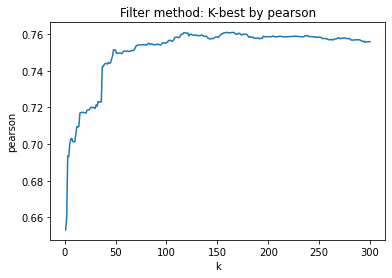

In [10]:
plt.plot(k_lst, pearson_lst)
plt.title('Filter method: K-best by pearson')
plt.xlabel('k')
plt.ylabel('pearson')

In [ ]:
k = 150

## Filter method: K-best by mutual information
- Alternative script in `feature_selection_single.py`.
- Results below _supposedly_ same as that in `single_train_mi.txt`.

In [ ]:
#col_2_multi_dim = {'glove_word':300, 'glove_word_sum':300, 'glove_word_head':300, 'glove_word_tail':300, 'glove_context':300, 'infersent_embeddings':4096, 'elmo_word':1024, 'elmo_word_sum':1024, 'elmo_word_head':1024, 'elmo_word_tail':1024}
#single_train = pd.read_csv('./data/'+job+'/single_train_j.tsv', sep='\t', index_col=0)
#discrete_features = discrete(single_train, col_2_multi_dim)

In [ ]:
#skb=SelectKBest(score_func=partial(mutual_info_regression,discrete_features=discrete_features),k=10)
#skb.fit(X_train_mini, y_train_mini)

In [10]:
feature_names, mi = get_sorted_mi('./data/'+job+'/single_train_mi.txt')
k_lst, pearson_lst = [], []

In [12]:
for k in tqdm(range(1, 300+1)):
    k_lst.append(k)
    picks = feature_names[:k]
    col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]
    X_train_mini_picks = X_train_mini[:, col_idx]
    X_dev_mini_picks = X_dev_mini[:, col_idx]
    model = LinearRegression()
    model = model.fit(X_train_mini_picks, y_train_mini)
    y_dev_mini_pred = model.predict(X_dev_mini_picks)
    pearson_lst.append(pearson(y_dev_mini_pred, y_dev_mini))

100%|██████████| 300/300 [00:34<00:00,  8.66it/s]


Text(0, 0.5, 'pearson')

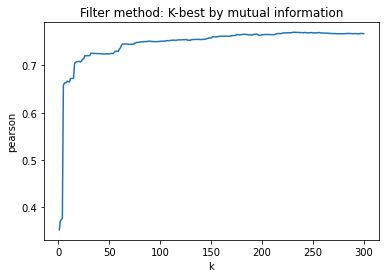

In [13]:
plt.plot(k_lst, pearson_lst)
plt.title('Filter method: K-best by mutual information')
plt.xlabel('k')
plt.ylabel('pearson')

In [ ]:
k = 300

## Filter: Remove constant features

In [12]:
X_df = pd.DataFrame(X, columns=[single_train_feature_idx_2_name[idx] for idx in range(X.shape[1])])
X_trial_df = pd.DataFrame(X_trial, columns=[single_trial_feature_idx_2_name[idx] for idx in range(X_trial.shape[1])])

In [13]:
constant_picks = [feature_name for feature_name in X_df if X_df[feature_name].std() == 0]
X_df.drop(labels=constant_picks, axis=1, inplace=True)
print(len(constant_picks))

24


## Filter: Remove quasi-constant features

In [14]:
selector = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
_ = selector.fit(X_df)  # fit finds the features with low variance
features_2_keep = X_df.columns[selector.get_support()]
X_df = X_df[features_2_keep.tolist()]
X_trial_df = X_trial_df[features_2_keep.tolist()]
sum(selector.get_support()) # how many not quasi-constant?

1494

In [15]:
picks = [pick for pick in feature_names[:300] if pick in X_df.columns]

## Filter method: Multicollinearity
- Decision: maybe don't remove multicollinearity as doing so might hurt Pearson of LR model.
- How about submitting model w/ multicollinearity, but interpretting model w/out multicollinearity?

In [16]:
picks = feature_names[:200]
col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])

In [17]:
X_train_mini_picks = X_train_mini[:, col_idx]
df = pd.DataFrame(X_train_mini_picks, columns=picks)

In [18]:
df.head()

,tf_summed_bpe,tf_lemma,tf,log_tf_lemma,log_tf,glove_word_277,glove_word_10,log_tf_ngram_2,glove_word_35,log_tf_summed_bpe,...,glove_word_9,glove_word_192,glove_word_76,glove_word_176,glove_word_198,glove_word_214,glove_word_16,infersent_embeddings_2577,infersent_embeddings_2563,glove_word_284
0,82107.0,82046.0,82046.0,11.315048,11.315048,-1.87880,-1.53350,7.928766,0.220650,11.315791,...,-0.345690,0.11192,0.59991,0.157700,0.42743,0.185570,-0.009047,0.000000,0.163330,0.11286
1,69287.0,69279.0,69279.0,11.145912,11.145912,-1.25200,-0.71337,7.469369,-1.256600,11.146027,...,0.304260,0.40821,0.56979,0.080208,-0.25046,-0.408960,-0.066453,-0.046265,0.167847,0.86633
2,6923.0,6920.0,6920.0,8.842316,8.842316,-0.55884,-1.54740,5.344724,0.457440,8.842749,...,0.297360,0.41008,0.34483,-0.176640,-0.32661,0.418100,-0.559510,-0.018555,0.220093,0.36162
3,73461.0,52833.0,52833.0,10.874910,10.874910,-1.58060,-1.72930,8.481773,-0.012829,11.204524,...,-0.480120,0.54379,0.10770,-0.497780,0.23375,0.428620,-0.240150,0.003603,0.191650,0.27033
4,2683091.0,409.0,409.0,6.016157,6.016157,0.21121,0.17107,3.650658,0.777420,14.802480,...,0.066095,-0.44474,0.45199,-0.698650,0.25177,-0.000025,-0.154800,0.025803,0.190796,0.53668


In [19]:
VIF = pd.DataFrame()
VIF['feature'] = picks
VIF['VIF'] = [variance_inflation_factor(df[picks].values, i) for i in range(len(picks))]

In [54]:
VIF_threshold = 10
VIF.sort_values('VIF', ascending=True, inplace=True)
picks = VIF[VIF['VIF'] <= VIF_threshold]['feature'].tolist()
col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]

In [26]:
picks = feature_names[:200]
col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]

In [35]:
X_train_mini_picks = X_train_mini[:, col_idx]
X_dev_mini_picks = X_dev_mini[:, col_idx]

In [36]:
model = LinearRegression()
_ = model.fit(X_train_mini_picks, y_train_mini)
X_dev_mini_picks = X_dev_mini[:, col_idx]
y_dev_mini_pred = model.predict(X_dev_mini_picks)
MAE(y_dev_mini_pred, y_dev_mini), pearson(y_dev_mini_pred, y_dev_mini), spearman(y_dev_mini_pred, y_dev_mini)

(0.07092311526845528, 0.729569968994637, 0.7099916651373972)

## Filter method: Decision tree

In [ ]:
rmse_values = []
for i in tqdm(range(X_train_mini.shape[1])):
    reg = DecisionTreeRegressor()
    reg.fit(X_train_mini[:, i].reshape(-1, 1), y_train_mini)
    y_dev_mini_pred = reg.predict(X_dev_mini[:, i].reshape(-1, 1))
    rmse_values.append(mean_squared_error(y_dev_mini, y_dev_mini_pred, squared=False))

In [ ]:
ranks = [(single_trial_feature_idx_2_name[i],rmse_value) for i,rmse_value in enumerate(rmse_values)]
ranks = sorted(ranks, key=lambda x: x[1])

## Wrapper method: Backward feature elimination (attempt)
- Ignored infersent_embeddings due to computation costs.
- Decision: takes long time.

In [ ]:
col_idx = [value for key, value in single_train_feature_name_2_idx.items() if not key.startswith('infersent_')]
picks = [single_train_feature_idx_2_name[idx] for idx in col_idx]

In [ ]:
X_train_mini_picks = X_train_mini[:, col_idx]

In [ ]:
X_train_mini_picks_1 = sm.add_constant(X_train_mini_picks)

In [ ]:
alpha = 0.05
picks = ['intercept'] + picks
for _ in tqdm(range(len(col_idx))):
    model = sm.OLS(y_train_mini, X_train_mini_picks_1).fit()
    pvalues = model.pvalues
    max_idx = np.argmax(pvalues)
    max_pvalue = pvalues[max_idx]
    if math.isnan(max_pvalue) or max_pvalue > alpha:
        X_train_mini_picks_1 = np.delete(X_train_mini_picks_1, max_idx, 1)
        del picks[max_idx]
    else:
        break
del picks[0]
X_train_mini_picks_1 = np.delete(X_train_mini_picks_1, 0, 1)

In [ ]:
X_train_mini_picks_1.shape

In [ ]:
#pkl.dump(picks, open('./data/'+job+'/picks_1_from_backward_elimination.pkl', 'wb'))
picks = pkl.load(open('./data/'+job+'/picks_1_from_backward_elimination.pkl', 'rb'))

## Wrapped methods: Forward feature selection

In [17]:
picks = [pick for pick in feature_names[:300] if pick in X_df.columns]
col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]
X_picks = X[:, col_idx]

In [18]:
model = LinearRegression()
sfs = SequentialFeatureSelector(model,
    k_features=100,#should be 200, but got away with it
    forward=True,
    floating=False,
    scoring='r2',
    verbose=2,
    cv=list(custom_cv_folds(single_train, n_splits=10)),
)

In [19]:
sfs.fit(X_picks, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    4.3s finished

[2021-01-18 15:54:18] Features: 1/100 -- score: 0.43854504411894546[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 274 out of 274 | elapsed:    4.5s finished

[2021-01-18 15:54:22] Features: 2/100 -- score: 0.49565480175481114[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 273 out of 273 | elapsed:    4.7s finished

[2021-01-18 15:54:27] Features: 3/100 -- score: 0.5331748616078319[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

SequentialFeatureSelector(cv=[(array([1329, 3006, 2292, ..., 7298, 7613, 3773]),
                               array([2799, 1890, 4597, 4021, 5163, 1188, 2402, 6557,  332, 3882, 2712,
       4139, 6289, 5420, 2868, 1611, 6105, 2298, 4718,  733, 1574, 4033,
       7547, 2287, 2758, 6738,  120, 7168, 3428,  753, 5136, 7455, 4774,
       4481, 4574, 5515, 2146, 5358, 5629, 5161, 1308, 6925, 6468, 7481,
        999, 5251, 3085, 5032, 5638, 5584,  220, 1601, 6407, 7630, 3903,...
       1947, 4172, 5127, 3126, 6891, 1206, 7230, 3007, 4573, 5507, 5046,
       2324, 6893, 5559, 3631,  260, 7656, 7639, 3735,   39, 3399, 5115,
        678, 7023, 3379, 5402, 2214,   10, 1643, 7065, 1594,  722, 4934,
       7384, 6157, 7420, 2788, 3888, 4159, 5384, 2432, 1832, 5857, 6521,
       1198, 1575, 1322, 5755, 4715, 1745, 2232,  815, 4312,  106, 6034,
       4498, 4796, 5923, 4939, 7387, 3543, 3810]))],
                          estimator=LinearRegression(), k_features=100,
                          scor

In [ ]:
k_features = 100

In [16]:
picks = [picks[idx] for idx in sfs.k_feature_idx_]
col_idx = [single_train_feature_name_2_idx[pick] for pick in picks]

picks = ['tf_summed_bpe', 'tf', 'log_tf_lemma', 'glove_word_277', 'glove_word_10', 'log_tf_ngram_2', 'glove_word_35', 'log_tf_summed_bpe', 'glove_word_201', 'glove_word_66', 'glove_word_100', 'glove_word_173', 'tf_ngram_3', 'glove_word_151', 'glove_word_255', 'glove_word_279', 'word_len', 'glove_word_155', 'glove_word_42', 'glove_word_187', 'log_tfidf_ngram_3', 'glove_word_296', 'glove_word_63', 'glove_word_25', 'glove_word_18', 'glove_word_235', 'glove_word_22', 'glove_word_248', 'glove_word_55', 'glove_word_210', 'glove_word_93', 'glove_word_38', 'glove_word_135', 'glove_word_295', 'glove_word_56', 'tfidf', 'glove_word_84', 'glove_word_262', 'glove_word_278', 'glove_word_286', 'glove_word_127', 'glove_word_268', 'glove_word_193', 'glove_word_251', 'glove_word_157', 'glove_word_102', 'glove_word_44', 'glove_word_14', 'glove_word_89', 'glove_word_131', 'log_is_acronym', 'glove_word_103', 'glove_word_123', 'glove_word_85', 'glove_word_114', 'glove_word_109', 'glove_word_128', 'glove_word_264', 'glove_word_203', 'glove_word_237', 'DaleChallIndex', 'infersent_embeddings_3496', 'glove_word_51', 'glove_word_88', 'glove_word_276', 'glove_word_213', 'glove_word_47', 'glove_word_292', 'glove_word_196', 'glove_word_174', 'glove_word_254', 'glove_word_283', 'glove_word_106', 'glove_word_241', 'glove_word_217', 'glove_word_39', 'glove_word_223', 'glove_word_141', 'log_num_hyponyms', 'glove_word_158', 'is_acronym', 'glove_word_37', 'glove_word_24', 'glove_word_2', 'elmo_word_488', 'POS_NNP', 'elmo_word_164', 'glove_word_5', 'glove_word_6', 'glove_word_16', 'glove_word_27', 'glove_word_79', 'num_syllables', 'glove_word_192', 'glove_word_232', 'glove_word_189', 'glove_word_175', 'glove_word_149', 'infersent_embeddings_2563', 'infersent_embeddings_3175']
col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])

## Wrapped methods: Forward feature selection (w/ mean(LR, MT-DNN))

In [8]:
with open('./data/'+job+'/colab/single_dev_mini_bert_scores.json', 'r') as file:
    single_dev_bert_scores = json.load(file)
    single_dev_mini['bert_pred_complexity'] = single_dev_bert_scores['scores']

In [14]:
class ModifiedLinearRegression(LinearRegression):
    def predict(self, X):
        single_dev_mini['lr_pred_complexity'] = self._decision_function(X)
        return single_dev_mini[['lr_pred_complexity', 'bert_pred_complexity']].mean(axis=1)

In [16]:
model = ModifiedLinearRegression()

In [17]:
sfs = SequentialFeatureSelector(model,
    k_features=100,
    #fixed_features=(X_picks.shape[1]-1,),
    forward=True,
    floating=False,
    scoring='r2',
    verbose=2,
    cv=[(single_train_mini_idx, single_dev_mini_idx)], 
    #cv=list(custom_cv_folds(single_train, n_splits=5)),
)

In [18]:
sfs.fit(X_picks, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished

[2021-01-13 02:27:21] Features: 1/100 -- score: 0.6057153198572787[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 199 out of 199 | elapsed:    0.6s finished

[2021-01-13 02:27:21] Features: 2/100 -- score: 0.6151337043681933[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:    0.7s finished

[2021-01-13 02:27:22] Features: 3/100 -- score: 0.6210379319849197[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

SequentialFeatureSelector(cv=[(array([5286,  481, 3500, ..., 1356, 1289, 4753]),
                               array([6053, 6753, 3027, 3443, 4015, 5529, 2366, 5791, 2158,  296, 3979,
       1633, 7332, 5297, 3247, 6846, 2249, 5227, 2076, 3954, 2688, 1205,
        772, 2389,   97, 1555, 2030, 6905, 2150, 3989, 5574, 6054, 3269,
       1413,  519,  230, 5254, 4520, 6192,  578, 5158, 1032, 3148, 4790,
       1931, 2439, 2226, 3268, 4915, 4425, 5572, 5738, 3791, 6938,  677,
        514...
       1156,  511, 6191,  317, 5737, 3744,  505, 2740, 2466, 6723,  782,
       3623, 6586, 6914, 5665, 7445, 3538, 6702, 3287, 2591, 3671,   75,
       1442, 3723, 6466,  922, 6324, 6791, 6393, 1725, 3001,  125,   12,
       1472,  193, 6510, 1418, 2603, 5014, 1025, 2780, 2125, 2039, 5281,
       5052, 3455, 3250, 2303, 2098, 6851, 2775,  999, 1396, 1501, 1564,
       2450, 3689, 5964, 2027,  669, 5777, 7194]))],
                          estimator=ModifiedLinearRegression(), k_features=100,
          

In [ ]:
k = 100

In [ ]:
[picks[idx] for idx in sfs.k_feature_idx_]

## Embedded methods: Regularization

In [82]:
scaler = MinMaxScaler()
X_picks_scaled = scaler.fit_transform(X_picks)
X_trial_picks_scaled = scaler.transform(X_trial_picks)

### Lasso regression

In [ ]:
model = Lasso(alpha=0.0001) # 1e-4 is optimal
model = model.fit(X_picks_scaled, y)
y_trial_pred = model.predict(X_trial_picks_scaled)
MAE(y_trial_pred, y_trial), pearson(y_trial_pred, y_trial), spearman(y_trial_pred, y_trial)

In [ ]:
plt.bar(range(len(picks)), model.coef_)

In [ ]:
sorted(list(zip(picks, model.coef_)), key=lambda x: np.abs(x[1]), reverse=True)[:10]

### Ridge regression
- Not worth it because ridge is preferred when we have small # of good features.

### ElasticNet

In [ ]:
model = ElasticNet(alpha=0.001, l1_ratio=0.3) # 1e-3 and 0.3 is optimal
model = model.fit(X_picks_scaled, y)
y_trial_pred = model.predict(X_trial_picks_scaled)
MAE(y_trial_pred, y_trial), pearson(y_trial_pred, y_trial), spearman(y_trial_pred, y_trial)

### Grid search

In [ ]:
model = ElasticNet()
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = np.arange(0, 1, 0.1)
search = GridSearchCV(model, grid, scoring='r2', cv=custom_cv_folds(single_train, n_splits=5), n_jobs=1, verbose=2)

## Embedded methods: Tree-based feature importances
- Ignored infersent_embeddings due to computation costs.

In [ ]:
col_idx = [value for key, value in single_train_feature_name_2_idx.items() if not key.startswith('infersent_')]
picks = [single_train_feature_idx_2_name[idx] for idx in col_idx]

In [ ]:
X_train_mini_picks = X_train_mini[:, col_idx]

In [ ]:
model = RandomForestRegressor()

In [ ]:
model.fit(X_train_mini_picks, y_train_mini)

In [ ]:
#pkl.dump(model.feature_importances_, open('./data/pickle/feature_importances_from_tree-based_feature_importances.pkl', 'wb'))
feature_importances = pkl.load(open('./data/pickle/feature_importances_from_tree-based_feature_importances.pkl', 'rb'))

In [ ]:
ranks = list(zip(picks, model.feature_importances_))
ranks = sorted(ranks, key=lambda x: x[1], reverse=True)

In [ ]:
ranks[:10]